In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
import json

warnings.filterwarnings('ignore')

# Ajouter src au path
sys.path.insert(0, str(Path.cwd().parent))

# MLflow
import mlflow
import mlflow.lightgbm
from mlflow.models.signature import infer_signature

# LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Modules du projet
from src.preprocessing import prepare_train_test_data, CreditScoringPreprocessor
from src.metrics import (
    find_optimal_threshold, 
    compute_all_metrics,
    plot_threshold_optimization,
    plot_confusion_matrix,
    plot_roc_curve,
    generate_metrics_report,
    COST_FN, COST_FP
)
from src.train import (
    setup_mlflow,
    get_default_lgb_params,
    train_lightgbm,
    train_with_mlflow,
    EXPERIMENT_NAME,
    MODEL_NAME
)

print(f"✅ Imports effectués")
print(f"   MLflow version: {mlflow.__version__}")
print(f"   LightGBM version: {lgb.__version__}")

✅ Imports effectués
   MLflow version: 3.7.0
   LightGBM version: 4.6.0


## 1. Configuration MLflow

In [2]:
# Configurer MLflow
MLFLOW_TRACKING_URI = "../mlruns"
experiment_id = setup_mlflow(MLFLOW_TRACKING_URI, EXPERIMENT_NAME)

print(f"\n📊 MLflow configuré:")
print(f"   Tracking URI: {MLFLOW_TRACKING_URI}")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Experiment ID: {experiment_id}")

✅ MLflow configuré:
   - Tracking URI: ../mlruns
   - Experiment: home-credit-scoring
   - Experiment ID: 992006039401835390

📊 MLflow configuré:
   Tracking URI: ../mlruns
   Experiment: home-credit-scoring
   Experiment ID: 992006039401835390


## 2. Préparation des Données

In [3]:
# Préparer les données (utiliser échantillon pour démo rapide)
X_train, X_test, y_train, test_ids, preprocessor = prepare_train_test_data(
    include_supplementary=True,
    sample_frac=0.3,  # 30% pour la démo
    save_preprocessor=True
)

print(f"\n📊 Données préparées:")
print(f"   X_train: {X_train.shape}")
print(f"   X_test: {X_test.shape}")
print(f"   Features: {len(preprocessor.feature_names)}")
print(f"   Target distribution: {np.bincount(y_train.astype(int))}")
print(f"   Taux de défaut: {y_train.mean()*100:.2f}%")

📊 Construction du dataset complet...
✅ Données chargées: train=(307511, 122), test=(48744, 121)
   ⚡ Échantillonnage: 30.0%
   🔧 Feature engineering application...
   📁 Agrégation bureau...
   📁 Agrégation previous_application...
   📁 Agrégation installments...
   📁 Agrégation POS_CASH...
   📁 Agrégation credit_card...
✅ Dataset construit: train=(92253, 246), test=(14623, 245)
✅ Préprocesseur fitted: 243 features
✅ Préprocesseur sauvegardé: /Users/jeffreylepage/Desktop/OPENCLASSROOMS/Lepage_Jeffrey_Réalisez_un_dashboard_et_assurez_une_veille_technique/home-credit-scoring/models/preprocessor.joblib
✅ Données préparées: X_train=(92253, 243), X_test=(14623, 243)

📊 Données préparées:
   X_train: (92253, 243)
   X_test: (14623, 243)
   Features: 243
   Target distribution: [84840  7413]
   Taux de défaut: 8.04%


In [4]:
# Split train/validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

print(f"\n📊 Split Train/Validation:")
print(f"   Train: {X_tr.shape[0]:,} échantillons")
print(f"   Validation: {X_val.shape[0]:,} échantillons")


📊 Split Train/Validation:
   Train: 73,802 échantillons
   Validation: 18,451 échantillons


## 3. Hyperparamètres du Modèle

In [5]:
# Paramètres LightGBM
params = get_default_lgb_params()

print("📊 Hyperparamètres LightGBM:")
for key, value in params.items():
    print(f"   {key}: {value}")

📊 Hyperparamètres LightGBM:
   objective: binary
   metric: auc
   boosting_type: gbdt
   num_leaves: 31
   learning_rate: 0.05
   feature_fraction: 0.8
   bagging_fraction: 0.8
   bagging_freq: 5
   max_depth: -1
   min_child_samples: 20
   reg_alpha: 0.1
   reg_lambda: 0.1
   n_estimators: 500
   early_stopping_rounds: 50
   verbose: -1
   random_state: 42
   n_jobs: -1
   class_weight: balanced


## 4. Entraînement avec MLflow Tracking

In [6]:
# Entraînement avec tracking MLflow complet
model, run_id, optimal_threshold = train_with_mlflow(
    X_train, y_train, preprocessor,
    params=params,
    test_size=0.2,
    run_name="lgbm_training_notebook",
    register_model=True
)

✅ MLflow configuré:
   - Tracking URI: mlruns
   - Experiment: home-credit-scoring
   - Experiment ID: 446811177754564983

📊 Données d'entraînement:
   - Train: 73802 échantillons
   - Validation: 18451 échantillons
   - Features: 243
   - Distribution target train: [67872  5930]

🚀 MLflow Run démarré: 169b2338d7224da2801ea8dda14d64e3

🏋️ Entraînement du modèle...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.763217
[200]	valid_0's auc: 0.767701
Early stopping, best iteration is:
[226]	valid_0's auc: 0.768321

🎯 Seuil optimal trouvé: 0.440

📈 Métriques de validation:
   - AUC: 0.7683
   - Accuracy: 0.7049
   - Precision: 0.1724
   - Recall: 0.7026
   - F1-Score: 0.2768
   - Coût métier: 9,413
✅ Graphique sauvegardé: /Users/jeffreylepage/Desktop/OPENCLASSROOMS/Lepage_Jeffrey_Réalisez_un_dashboard_et_assurez_une_veille_technique/home-credit-scoring/reports/threshold_optimization.png
✅ Matrice de confusion sauvegardée: /Users/jeffreylepage/Desktop/OP

2025/12/11 18:11:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Entraînement terminé!
   - Run ID: 169b2338d7224da2801ea8dda14d64e3
   - Modèle sauvegardé: /Users/jeffreylepage/Desktop/OPENCLASSROOMS/Lepage_Jeffrey_Réalisez_un_dashboard_et_assurez_une_veille_technique/home-credit-scoring/models/lgbm_model.joblib
   - Modèle enregistré dans MLflow: home_credit_model


Registered model 'home_credit_model' already exists. Creating a new version of this model...
Created version '2' of model 'home_credit_model'.


In [7]:
# Résumé de l'entraînement
print(f"\n" + "="*60)
print(f"RÉSUMÉ DE L'ENTRAÎNEMENT")
print("="*60)
print(f"\n📊 Run ID: {run_id}")
print(f"🎯 Seuil optimal: {optimal_threshold:.4f}")
print(f"💰 Coûts métier: FN={COST_FN}, FP={COST_FP}")
print(f"\n📁 Artifacts sauvegardés dans ../reports/")


RÉSUMÉ DE L'ENTRAÎNEMENT

📊 Run ID: 169b2338d7224da2801ea8dda14d64e3
🎯 Seuil optimal: 0.4400
💰 Coûts métier: FN=10, FP=1

📁 Artifacts sauvegardés dans ../reports/


## 5. Analyse des Résultats

In [8]:
# Prédictions sur validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

y_proba_val = model.predict_proba(X_val)[:, 1]

# Rapport complet
report = generate_metrics_report(y_val.values, y_proba_val, COST_FN, COST_FP)
print(report)


                    RAPPORT DE MÉTRIQUES - HOME CREDIT SCORING

PARAMÈTRES MÉTIER:
  - Coût Faux Négatif (FN): 10 (client en défaut non détecté)
  - Coût Faux Positif (FP): 1 (bon client refusé)

--------------------------------------------------------------------------------
SEUIL PAR DÉFAUT (0.5):
--------------------------------------------------------------------------------
  AUC:              0.7683
  Accuracy:         0.7550
  Precision:        0.1895
  Recall:           0.6251
  F1-Score:         0.2909
  
  Matrice de confusion:
    TP: 927  |  FP: 3,964
    FN: 556  |  TN: 13,004
  
  Coût métier:      9,524

--------------------------------------------------------------------------------
SEUIL OPTIMAL (0.44):
--------------------------------------------------------------------------------
  AUC:              0.7683
  Accuracy:         0.7049
  Precision:        0.1724
  Recall:           0.7026
  F1-Score:         0.2768
  
  Matrice de confusion:
    TP: 1,042  |  FP: 5,00

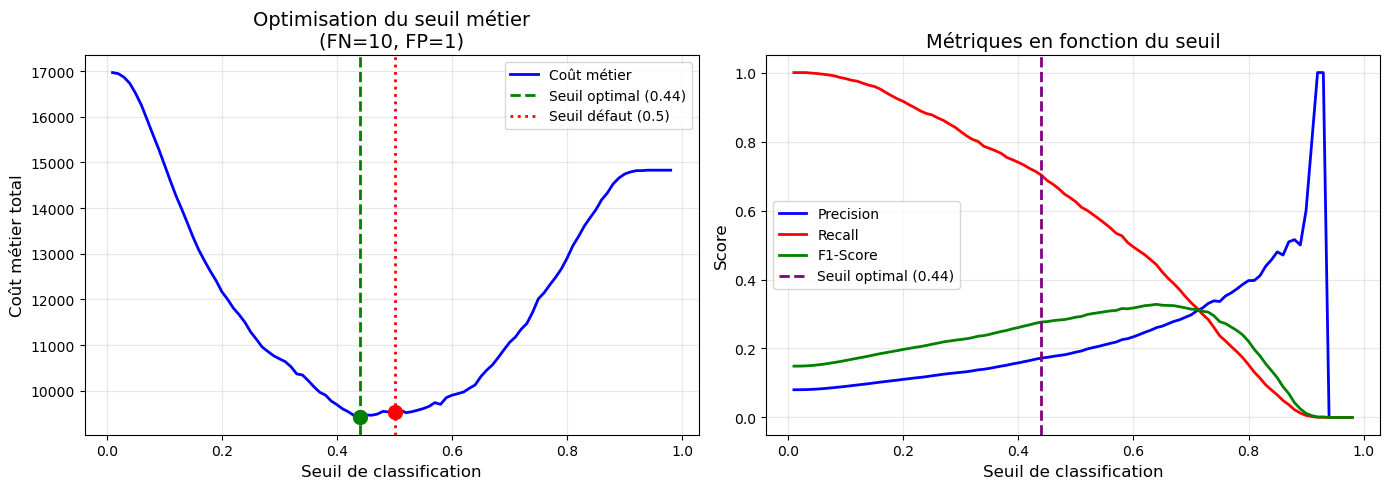

In [9]:
# Visualiser l'optimisation du seuil
fig = plot_threshold_optimization(y_val.values, y_proba_val, COST_FN, COST_FP)
plt.show()

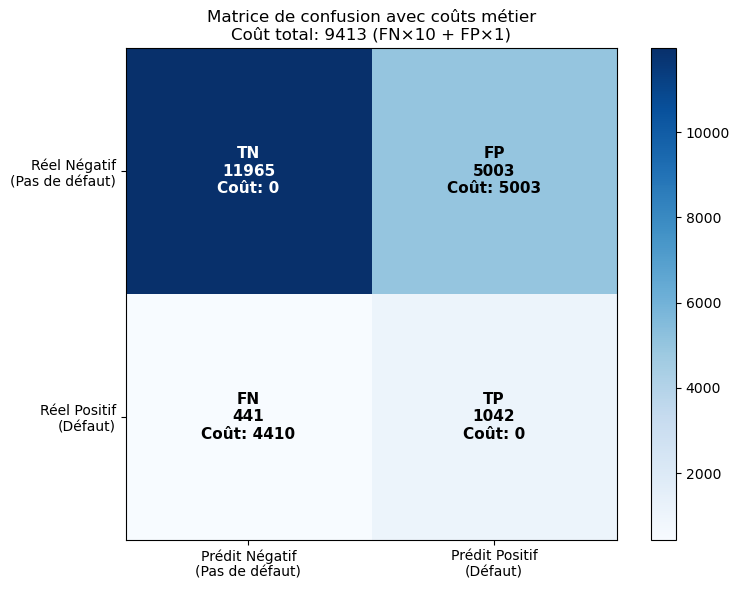

In [10]:
# Matrice de confusion
y_pred_val = (y_proba_val >= optimal_threshold).astype(int)
fig = plot_confusion_matrix(y_val.values, y_pred_val, COST_FN, COST_FP)
plt.show()

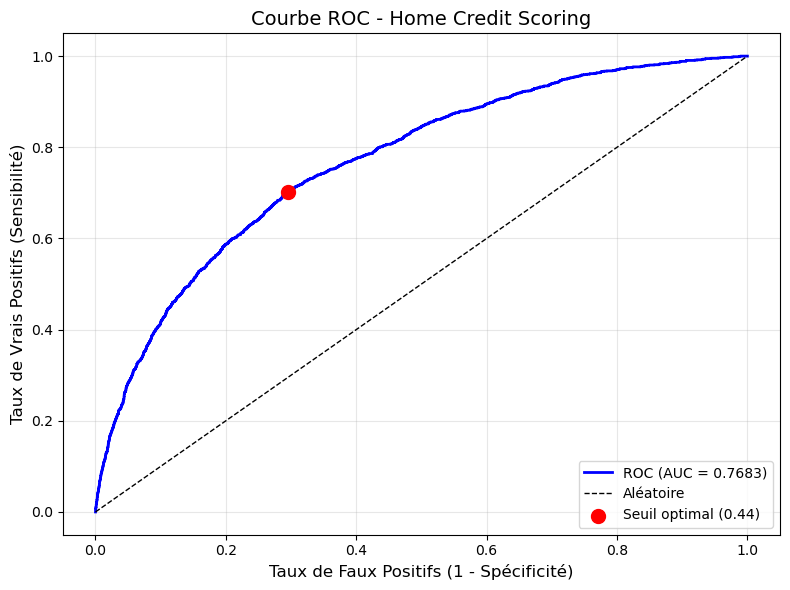

In [11]:
# Courbe ROC
fig = plot_roc_curve(y_val.values, y_proba_val, optimal_threshold)
plt.show()

## 6. Feature Importance

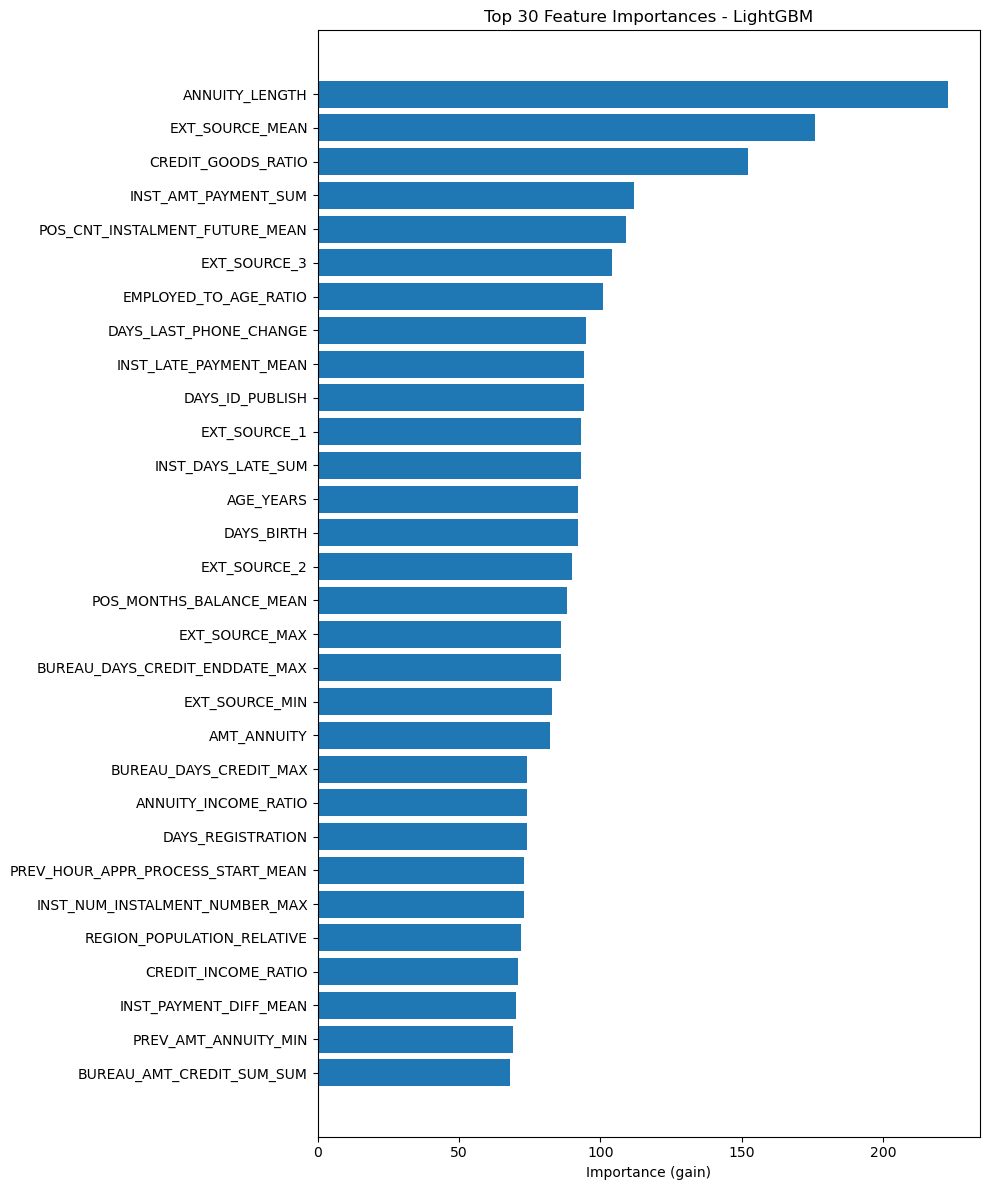

In [12]:
# Importance des features
feature_importance = pd.DataFrame({
    'feature': preprocessor.feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20
top_n = 30
fig, ax = plt.subplots(figsize=(10, 12))
ax.barh(range(top_n), feature_importance['importance'].head(top_n))
ax.set_yticks(range(top_n))
ax.set_yticklabels(feature_importance['feature'].head(top_n))
ax.invert_yaxis()
ax.set_xlabel('Importance (gain)')
ax.set_title(f'Top {top_n} Feature Importances - LightGBM')
plt.tight_layout()
plt.savefig('../reports/feature_importance_top30.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Afficher top 20 features
print("\n📊 Top 20 Features:")
for i, row in feature_importance.head(20).iterrows():
    print(f"   {row['feature']}: {row['importance']:.2f}")


📊 Top 20 Features:
   ANNUITY_LENGTH: 223.00
   EXT_SOURCE_MEAN: 176.00
   CREDIT_GOODS_RATIO: 152.00
   INST_AMT_PAYMENT_SUM: 112.00
   POS_CNT_INSTALMENT_FUTURE_MEAN: 109.00
   EXT_SOURCE_3: 104.00
   EMPLOYED_TO_AGE_RATIO: 101.00
   DAYS_LAST_PHONE_CHANGE: 95.00
   INST_LATE_PAYMENT_MEAN: 94.00
   DAYS_ID_PUBLISH: 94.00
   EXT_SOURCE_1: 93.00
   INST_DAYS_LATE_SUM: 93.00
   AGE_YEARS: 92.00
   DAYS_BIRTH: 92.00
   EXT_SOURCE_2: 90.00
   POS_MONTHS_BALANCE_MEAN: 88.00
   EXT_SOURCE_MAX: 86.00
   BUREAU_DAYS_CREDIT_ENDDATE_MAX: 86.00
   EXT_SOURCE_MIN: 83.00
   AMT_ANNUITY: 82.00


## 7. Prédictions sur le Jeu de Test

In [14]:
# Prédictions sur test
y_proba_test = model.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

print(f"\n📊 Prédictions sur le jeu de test:")
print(f"   Total: {len(y_proba_test):,}")
print(f"   Prédits défaut (1): {y_pred_test.sum():,} ({y_pred_test.mean()*100:.2f}%)")
print(f"   Prédits non-défaut (0): {(1-y_pred_test).sum():,}")


📊 Prédictions sur le jeu de test:
   Total: 14,623
   Prédits défaut (1): 4,686 (32.05%)
   Prédits non-défaut (0): 9,937


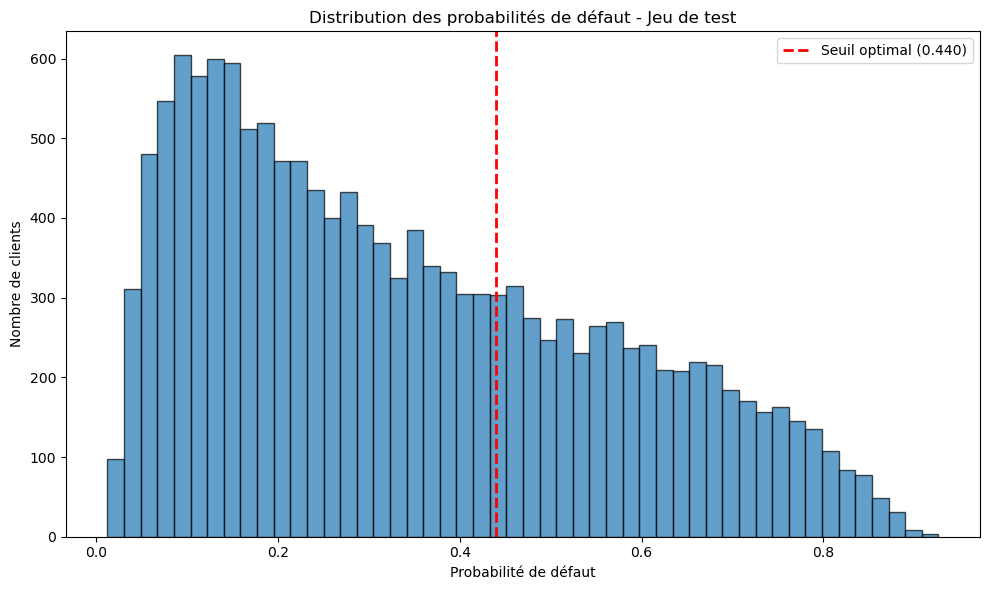

In [15]:
# Distribution des probabilités
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(y_proba_test, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(x=optimal_threshold, color='red', linestyle='--', linewidth=2, 
           label=f'Seuil optimal ({optimal_threshold:.3f})')
ax.set_xlabel('Probabilité de défaut')
ax.set_ylabel('Nombre de clients')
ax.set_title('Distribution des probabilités de défaut - Jeu de test')
ax.legend()
plt.tight_layout()
plt.savefig('../reports/test_probabilities_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Sauvegarder les prédictions
predictions = test_ids.copy()
predictions['TARGET_PROBA'] = y_proba_test
predictions['TARGET_PRED'] = y_pred_test
predictions['RISK_CATEGORY'] = pd.cut(
    y_proba_test, 
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Très faible', 'Faible', 'Modéré', 'Élevé', 'Très élevé']
)

predictions.to_csv('../models/test_predictions.csv', index=False)
print(f"\n✅ Prédictions sauvegardées: ../models/test_predictions.csv")

# Format soumission Kaggle
submission = test_ids.copy()
submission['TARGET'] = y_proba_test
submission.to_csv('../models/submission.csv', index=False)
print(f"✅ Soumission Kaggle: ../models/submission.csv")


✅ Prédictions sauvegardées: ../models/test_predictions.csv
✅ Soumission Kaggle: ../models/submission.csv


## 8. Visualiser les Expériences MLflow

In [17]:
# Lister les runs
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

print(f"\n📊 Runs dans l'expérience '{EXPERIMENT_NAME}':")
if len(runs) > 0:
    display_cols = ['run_id', 'start_time', 'metrics.val_auc', 'metrics.val_business_cost', 'metrics.optimal_threshold']
    display_cols = [c for c in display_cols if c in runs.columns]
    print(runs[display_cols].head(10))
else:
    print("   Aucun run trouvé")


📊 Runs dans l'expérience 'home-credit-scoring':
                             run_id                       start_time  \
0  169b2338d7224da2801ea8dda14d64e3 2025-12-11 17:10:57.846000+00:00   
1  fe2140dd589f42f8a660012531d17f3f 2025-12-11 17:05:55.802000+00:00   

   metrics.val_auc  metrics.val_business_cost  metrics.optimal_threshold  
0         0.768321                     9413.0                       0.44  
1         0.768321                     9413.0                       0.44  


In [18]:
# Instructions pour MLflow UI
print("\n" + "="*60)
print("📊 VISUALISER MLFLOW UI")
print("="*60)
print(f"""
Pour visualiser l'interface MLflow:

1. Ouvrir un terminal
2. Naviguer vers le projet: cd home-credit-scoring
3. Lancer: mlflow ui --backend-store-uri mlruns
4. Ouvrir: http://localhost:5000

Vous pourrez voir:
- Tous les runs avec leurs métriques
- Les paramètres utilisés
- Les artifacts (graphiques, modèle)
- Le modèle enregistré: {MODEL_NAME}
""")


📊 VISUALISER MLFLOW UI

Pour visualiser l'interface MLflow:

1. Ouvrir un terminal
2. Naviguer vers le projet: cd home-credit-scoring
3. Lancer: mlflow ui --backend-store-uri mlruns
4. Ouvrir: http://localhost:5000

Vous pourrez voir:
- Tous les runs avec leurs métriques
- Les paramètres utilisés
- Les artifacts (graphiques, modèle)
- Le modèle enregistré: home_credit_model



## Résumé

### Modèle entraîné:
- **Algorithme:** LightGBM Classifier
- **Features:** ~200+ après feature engineering
- **Seuil optimal:** Optimisé pour minimiser coût(FN)×10 + coût(FP)×1

### MLflow Tracking:
- **Paramètres:** Tous les hyperparamètres loggés
- **Métriques:** AUC, accuracy, precision, recall, F1, business cost
- **Artifacts:** Graphiques, feature importance, rapport
- **Registry:** Modèle enregistré comme `home_credit_model`

### Fichiers générés:
- `models/lgbm_model.joblib`: Modèle sérialisé
- `models/preprocessor.joblib`: Préprocesseur
- `models/model_config.json`: Configuration (seuil, etc.)
- `models/submission.csv`: Format Kaggle
- `reports/*.png`: Visualisations